# Cryptocurrency Dashboard

In [1]:
#%load_ext watermark

import requests
import time
import hmac
import hashlib
import pandas as pd 
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from datetime import datetime, timedelta
import mercury as mr

#%watermark -p requests

In [2]:
# Set up API keys and URL
import keys

# CoinMarketCap API
CMC_API_KEY = keys.CMC_API_KEY
CMC_API_URL_LATEST = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'

# Binance API
BINANCE_API_KEY = keys.BINANCE_API_KEY
BINANCE_API_SECRETKEY = keys.BINANCE_SECRET_KEY

AttributeError: module 'keys' has no attribute 'CMC_API_KEY'

In [ ]:
# add Markdown note in the left sidebar in Mercury
_ = mr.Note(text="**Information:** \
All price data displayed is fetched from [https://binance.com](https://binance.us). \
For US-Version, details and more projects visit my GitHub. \
[https://github.com/kuranez/Krypto-Dashboard](https://github.com/kuranez/Krypto-Dashboard)")

## Current Price vs. All-Time-High

In [6]:
# Function to fetch all-time historical data from Binance
def fetch_alltime_data(symbol='BTCUSDT', interval='1d', start_time=None, end_time=None, limit=1000):
    url = 'https://api.binance.com/api/v3/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit,
    }
    if start_time:
        params['startTime'] = start_time
    if end_time:
        params['endTime'] = end_time
    headers = {
        'X-MBX-APIKEY': BINANCE_API_KEY
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        print(f"Error: {response.status_code}, {response.text}")
        return None
    data = response.json()
    return data

In [7]:
# Function to fetch the current price
def fetch_current_price(symbol='BTCUSDT'):
    url = f'https://api.binance.com/api/v3/ticker/price?symbol={symbol}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return float(data['price'])
    else:
        print(f"Error fetching current price for {symbol}: {response.status_code}, {response.text}")
        return None

In [8]:
# Function to calculate the percentage change
def calculate_percent_change(current_price, ath):
    if ath == 0:
        return None
    return ((current_price - ath) / ath) * 100

In [9]:
# List of symbols to fetch (BTC, ETH, BNB)
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
ath_dict = {}
current_price_dict = {}
percent_change_dict = {}

In [10]:
# Loop through each symbol and fetch historical data and current price
for symbol in symbols:
    #print(f"Fetching data for {symbol}...")
    alltime_data = fetch_alltime_data(symbol=symbol)
    current_price = fetch_current_price(symbol=symbol)
    
    if alltime_data:  # Check if the data is available
        df = pd.DataFrame(alltime_data, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
                                                 'Close Time', 'Quote Asset Volume', 'Number of Trades',
                                                 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume',
                                                 'Ignore'])

        df = df[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']]
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        df['Date'] = pd.to_datetime(df['Date'], unit='ms')
        
        ath = df['High'].max()
        ath = round(float(ath), 2)

        # Calculate percentage change from ATH
        percent_change_from_ath = round(calculate_percent_change(current_price, ath), 2)
        
        # Save ATH, percentage change and current price to dictionaries
        if symbol == 'BTCUSDT':
            ath_dict['BTC'] = ath
            current_price_dict['BTC'] = current_price
            percent_change_dict['BTC'] = percent_change_from_ath
        elif symbol == 'ETHUSDT':
            ath_dict['ETH'] = ath
            current_price_dict['ETH'] = current_price
            percent_change_dict['ETH'] = percent_change_from_ath
        elif symbol == 'BNBUSDT':
            ath_dict['BNB'] = ath
            current_price_dict['BNB'] = current_price
            percent_change_dict['BNB'] = percent_change_from_ath

NameError: name 'BINANCE_API_KEY' is not defined

In [11]:
# Prepare data for Plotly
assets = list(ath_dict.keys())
ath_values = list(ath_dict.values())
current_prices = list(current_price_dict.values())
percent_changes = list(percent_change_dict.values())

In [9]:
# Print results (for debugging or inspection)
#print("Symbol:", assets)
#print("ATH Values:", ath_values)
#print("Current Prices:", current_prices)
#print("Percent Changes:", percent_changes)

In [10]:
# Colors for Figures
colors_a = {
    'BTC': 'orange',
    'ETH': 'mediumpurple',
    'BNB': 'indianred'
}

colors_b = {
    'BTC': 'gold',
    'ETH': 'plum',
    'BNB': 'lightsalmon'
}

In [11]:
# Convert named colors to rgba with 80% opacity
def convert_color_with_opacity80(color_name, opacity=0.8):
     # Convert the color name to an RGBA tuple with the specified opacity
    rgba = mcolors.to_rgba(color_name, opacity)
     # Return result and format the RGBA values into a string
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

# Convert named colors to rgba with 60% opacity
def convert_color_with_opacity60(color_name, opacity=0.6):
    rgba = mcolors.to_rgba(color_name, opacity)
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

# Convert named colors to rgba with 40% opacity
def convert_color_with_opacity40(color_name, opacity=0.4):
    rgba = mcolors.to_rgba(color_name, opacity)
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

In [12]:
# Colors to Hex for Mercury Widgets
def convert_and_print_hex(*args):
    # Print title
    print("# Colors:")

    # Format printed output
    for index, colors_dict in enumerate(args):
        # Create a list of formatted strings for each key-value pair in the dictionary
        formatted_colors = [f'{label}: {convert_color_name_to_hex(color_name)}' for label, color_name in colors_dict.items()]
        
        # Join the list into a single string with commas separating entries
        result = ', '.join(formatted_colors)
        
        # Print the result with the corresponding index
        print(f'# {chr(97 + index)}) {result}')

def convert_color_name_to_hex(color_name):
    rgb = mcolors.to_rgb(color_name)
    hex_color = '#{:02X}{:02X}{:02X}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
    return hex_color

# Convert and print the dictionaries
#convert_and_print_hex(colors_a, colors_b)

# Colors:
# a) BTC: #FFA500, ETH: #9370DB, BNB: #CD5C5C
# b) BTC: #FFD700, ETH: #DDA0DD, BNB: #FFA07A

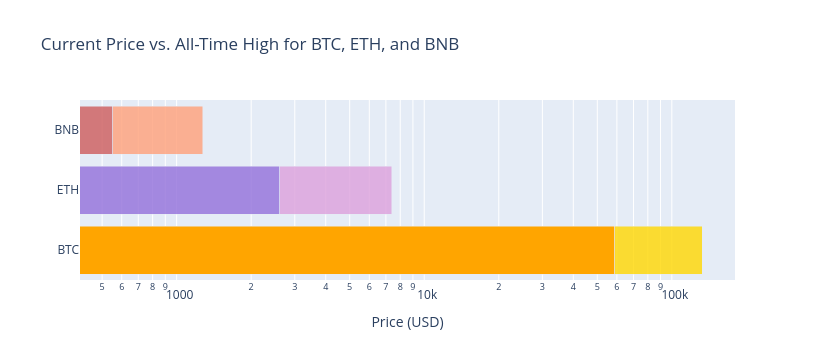

In [13]:
# Create stacked bar chart using Plotly with prices on the x-axis
fig = go.Figure()

# Add BTC bars
fig.add_trace(go.Bar(
    name='BTC Current Price', 
    y=['BTC'], 
    x=[current_price_dict['BTC']], 
    marker_color=colors_a['BTC'],
    orientation='h'  # Horizontal bar
))
fig.add_trace(go.Bar(
    name='BTC ATH', 
    y=['BTC'], 
    x=[ath_dict['BTC']], 
    marker_color=convert_color_with_opacity80(colors_b['BTC']),
    orientation='h',  # Horizontal bar
    #text=[ath_dict['BTC']],  # Display ATH value as text
    #textposition='inside'  # Position the text outside the bar
    #text=[percent_change_dict['BTC']],  # Display ATH value as text
    #textposition='outside'  # Position the text outside the bar
))

# Add ETH bars
fig.add_trace(go.Bar(
    name='ETH Current Price', 
    y=['ETH'], 
    x=[current_price_dict['ETH']], 
    marker_color=convert_color_with_opacity80(colors_a['ETH']),
    orientation='h'  # Horizontal bar
))
fig.add_trace(go.Bar(
    name='ETH ATH', 
    y=['ETH'], 
    x=[ath_dict['ETH']], 
    marker_color=convert_color_with_opacity80(colors_b['ETH']),
    orientation='h'  # Horizontal bar
))

# Add BNB bars
fig.add_trace(go.Bar(
    name='BNB Current Price', 
    y=['BNB'], 
    x=[current_price_dict['BNB']], 
    marker_color=convert_color_with_opacity80(colors_a['BNB']),
    orientation='h'  # Horizontal bar
))
fig.add_trace(go.Bar(
    name='BNB ATH', 
    y=['BNB'], 
    x=[ath_dict['BNB']], 
    marker_color=convert_color_with_opacity80(colors_b['BNB']),
    orientation='h'  # Horizontal bar
))

# Customize layout
fig.update_layout(
    title="Current Price vs. All-Time High for BTC, ETH, and BNB",
    xaxis_title="Price (USD)",
    #yaxis_title="Cryptocurrency",
    barmode='stack',  # Stacked bars
    xaxis_type='log',  # Logarithmic scale
    showlegend=False,  # Hide the legend
)

# Show the figure
fig.show()

In [14]:
#Set Boxes with Numbers
latest_price_box = mr.NumberBox([
        mr.NumberBox(data=f"{current_price_dict['BTC']} $", title=f"{'BTC'}", title_color="#FFA500", data_color="#FFA500", border_color="#FFA500"),
        mr.NumberBox(data=f"{current_price_dict['ETH']} $", title=f"{'ETH'}", title_color="#9370DB", data_color="#9370DB", border_color="#9370DB"),
        mr.NumberBox(data=f"{current_price_dict['BNB']} $", title=f"{'BNB'}", title_color="#CD5C5C", data_color="#CD5C5C", border_color="#CD5C5C"),
        ])

ath_price_box = mr.NumberBox([
        mr.NumberBox(data=f"{ath_dict['BTC']} $", title=f"{'BTC ATH'}", title_color="#FFD700", data_color="#FFD700", border_color="#FFD700"),
        mr.NumberBox(data=f"{ath_dict['ETH']} $", title=f"{'ETH ATH'}", title_color="#DDA0DD", data_color="#DDA0DD", border_color="#DDA0DD"),
        mr.NumberBox(data=f"{ath_dict['BNB']} $", title=f"{'BNB ATH'}", title_color="#FFA07A", data_color="#FFA07A", border_color="#FFA07A"),
        ])

percent_ath_price_box = mr.NumberBox([
        mr.NumberBox(data=f"{percent_change_dict['BTC']} %", title=f"{'BTC ATH'}", title_color="#FFD700", data_color="#FFD700", border_color="#FFD700"),
        mr.NumberBox(data=f"{percent_change_dict['ETH']} %", title=f"{'ETH ATH'}", title_color="#DDA0DD", data_color="#DDA0DD", border_color="#DDA0DD"),
        mr.NumberBox(data=f"{percent_change_dict['BNB']} %", title=f"{'BNB ATH'}", title_color="#FFA07A", data_color="#FFA07A", border_color="#FFA07A"),
        ])    

# Colors:
# a) BTC: #FFA500, ETH: #9370DB, BNB: #CD5C5C
# b) BTC: #FFD700, ETH: #DDA0DD, BNB: #FFA07A

In [15]:
display(latest_price_box, ath_price_box, percent_ath_price_box)

## Last 52 Weeks Price & Volume Comparison

In [16]:
# Function to fetch historical data from Binance
def fetch_historical_data(symbol='BTCUSDT', interval='1d', start_time=None, end_time=None, limit=1000):
    # Binance API URL for Kline data
    url = 'https://api.binance.com/api/v3/klines'
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit,
    }
    
    if start_time:
        params['startTime'] = start_time
    if end_time:
        params['endTime'] = end_time

    # Add API key to the header
    headers = {
        'X-MBX-APIKEY': BINANCE_API_KEY
    }

    response = requests.get(url, headers=headers, params=params)

    # Debugging: Check the status code and response data
    if response.status_code != 200:
        print(f"Error: {response.status_code}, {response.text}")
        return None
    
    data = response.json()
    
    # Check if data is empty or not in the expected format
    if not data or isinstance(data, dict):
        print(f"No data or unexpected data format received for {symbol}: {data}")
        return None
    
    return data

In [17]:
# Calculate the start and end times for the last 52 weeks
end_time = int(datetime.now().timestamp() * 1000)  # Current time in milliseconds
start_time = int((datetime.now() - timedelta(weeks=52)).timestamp() * 1000)  # 52 weeks ago in milliseconds

In [18]:
# List of symbols to fetch (BTC, ETH, BNB)
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']

In [19]:
# Dictionary to hold the 52-week high and low for each symbol
high_low_dict = {}

In [20]:
# Moving Average Periods
short_window = 50  # 50-day Moving Average
long_window = 200  # 200-day Moving Average

In [21]:
# Initialize a list to hold dataframes
dataframes = []

# Fetch data for each symbol and store it in the list
for symbol in symbols:
    #print(f"Fetching data for {symbol}...")
    historical_data = fetch_historical_data(symbol=symbol, start_time=start_time, end_time=end_time)

    if historical_data:
        # Convert to DataFrame and check the data structure
        df = pd.DataFrame(historical_data)
        
        # Display the first few rows of the DataFrame for debugging
        #print(f"Data for {symbol}:\n", df.head())

        # Check if expected columns exist
        if df.empty or len(df.columns) < 2:
            print(f"Dataframe for {symbol} does not have enough columns.")
            continue
        
        # Extract relevant columns
        df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 
                      'Close Time', 'Quote Asset Volume', 'Number of Trades', 
                      'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 
                      'Ignore']  # Ensure columns are named properly

        # Use the 'Close' price for comparison
        df = df[['Open Time', 'Close', 'High', 'Low', 'Volume']]
        df['Date'] = pd.to_datetime(df['Open Time'], unit='ms')
        df['Symbol'] = symbol[:-4]  # Add symbol column (removing 'USDT')

        # Calculate moving averages
        df['SMA_50'] = df['Close'].astype(float).rolling(window=short_window).mean()
        df['SMA_200'] = df['Close'].astype(float).rolling(window=long_window).mean()

         # Calculate Exponential Moving Averages (EMA)
        df['EMA_50'] = df['Close'].astype(float).ewm(span=short_window, adjust=False).mean()
        df['EMA_200'] = df['Close'].astype(float).ewm(span=long_window, adjust=False).mean()

        # Calculate 52-week high and low
        high_52wk = df['High'].max()
        high_52wk = round(float(high_52wk), 2)
        low_52wk = df['Low'].min()
        low_52wk = round(float(low_52wk), 2)
        
                    
        # Store the high and low in the dictionary
        high_low_dict[symbol[:-4]] = {'High': high_52wk, 'Low': low_52wk}
        
        dataframes.append(df)

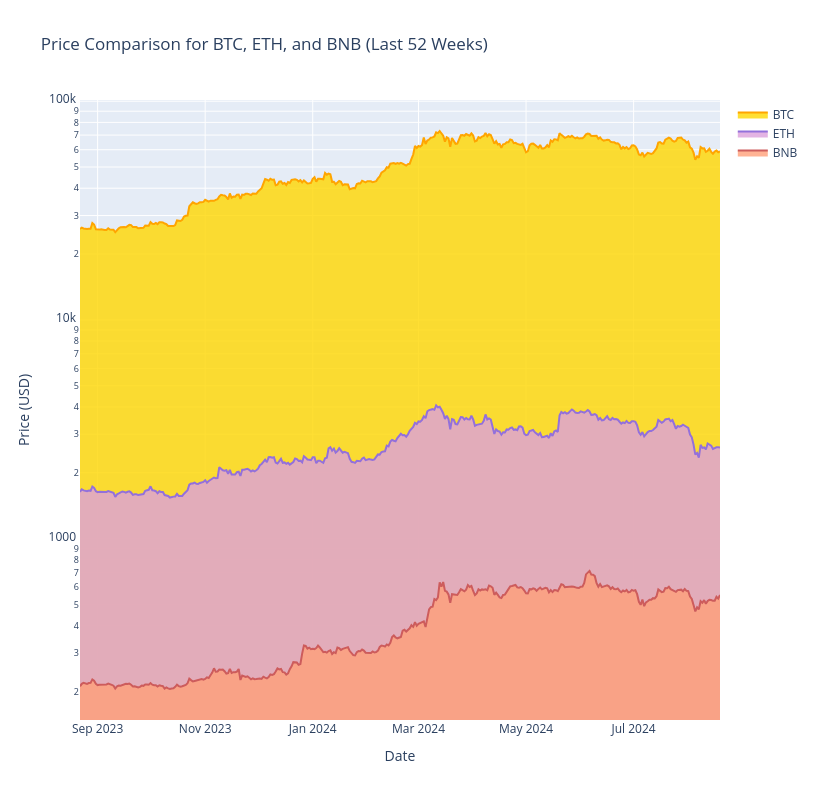

In [22]:
# Combine all dataframes into one
if dataframes:
    combined_df = pd.concat(dataframes)
    
    # Plot the high, low, and closing prices using Plotly
    fig = go.Figure()

    # Add line traces for each symbol
    for symbol in symbols:
        symbol_name = symbol[:-4]  # Get the symbol without 'USDT'
        symbol_df = combined_df[combined_df['Symbol'] == symbol_name]

        # Add Price traces using the same color for each symbol
        fig.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['Close'],
            mode='lines',
            name=f'{symbol_name}',
            line=dict(color=colors_a[symbol_name]),  # Solid line for Close
            fill='tozeroy',  # Fill area under the curve to the x-axis
            fillcolor=convert_color_with_opacity80(colors_b[symbol_name]) 
        ))

    # Update layout for the plot with logarithmic scale
    fig.update_layout(
        title='Price Comparison for BTC, ETH, and BNB (Last 52 Weeks)',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        yaxis_type='log',  # Set y-axis to logarithmic scale
        height=800,
        #width=1000
    )

    # Show the figure
    fig.show()
    
else:
    print("No historical data available for any symbols.")

In [23]:
#Set Boxes with Numbers
wk52_low_box = mr.NumberBox([
        mr.NumberBox(data=f"{high_low_dict['BTC']['Low']} $", title=f"{'BTC Low'}", title_color="#FFD700", data_color="#FFD700", border_color="#FFD700"),
        mr.NumberBox(data=f"{high_low_dict['ETH']['Low']} $", title=f"{'ETH Low'}", title_color="#DDA0DD", data_color="#DDA0DD", border_color="#DDA0DD"),
        mr.NumberBox(data=f"{high_low_dict['BNB']['Low']} $", title=f"{'BNB Low'}", title_color="#FFA07A", data_color="#FFA07A", border_color="#FFA07A"),
        ])

wk52_high_box = mr.NumberBox([
        mr.NumberBox(data=f"{high_low_dict['BTC']['High']} $", title=f"{'BTC High'}", title_color="#FFA500", data_color="#FFA500", border_color="#FFA500"),
        mr.NumberBox(data=f"{high_low_dict['ETH']['High']} $", title=f"{'ETH High'}", title_color="#9370DB", data_color="#9370DB", border_color="#9370DB"),
        mr.NumberBox(data=f"{high_low_dict['BNB']['High']} $", title=f"{'BNB High'}", title_color="#CD5C5C", data_color="#CD5C5C", border_color="#CD5C5C"),
        ])

# Colors:
# a) BTC: #FFA500, ETH: #9370DB, BNB: #CD5C5C
# b) BTC: #FFD700, ETH: #DDA0DD, BNB: #FFA07A

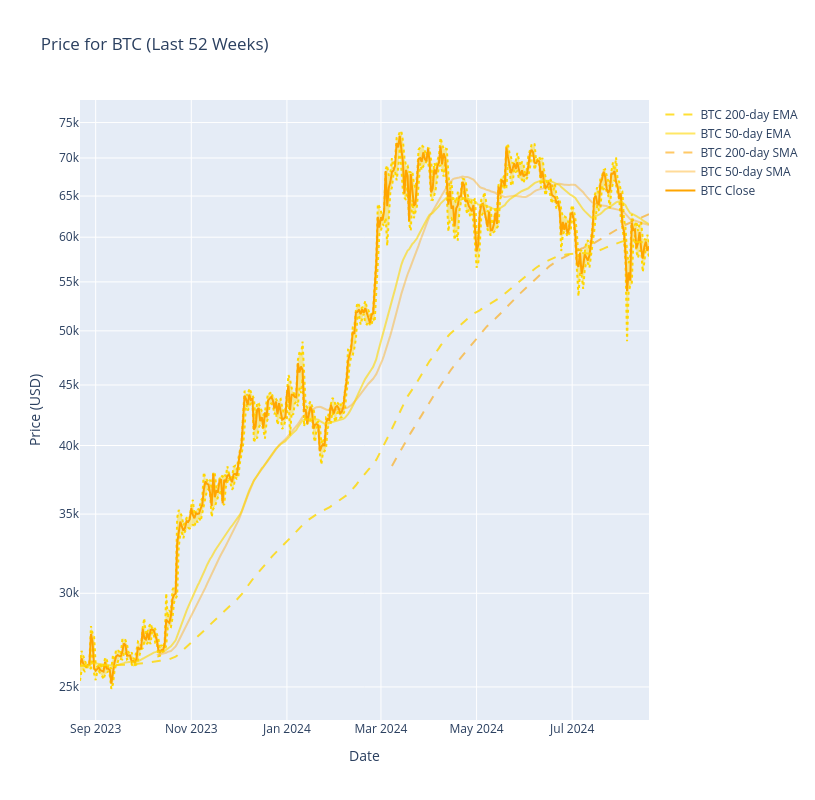

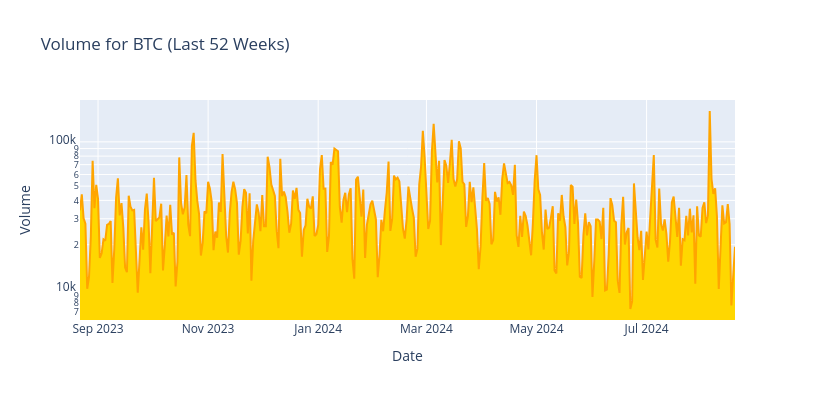

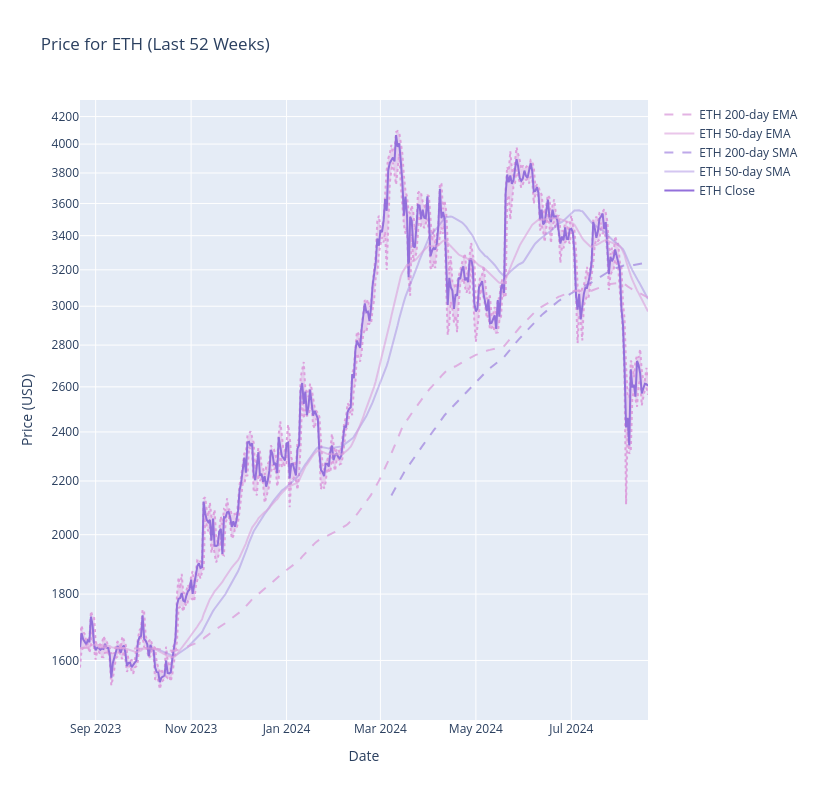

In [24]:
# Combine all dataframes into one
if dataframes:
    combined_df = pd.concat(dataframes)

    # Create Plots in a Loop to display in separate and combined charts
    for symbol in symbols:
        symbol_name = symbol[:-4]  # Get the symbol without 'USDT'
        symbol_df = combined_df[combined_df['Symbol'] == symbol_name]

        # Create a new figure for the current symbol
        fig1 = go.Figure()
        fig2 = go.Figure()
        
        # High-Low Band Plot
        fig1.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['High'],
            mode='lines',
            name=f'{symbol_name} High',
            line=dict(color=colors_b[symbol_name], dash='dot'),
            showlegend=False
        ))

        fig1.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['Low'],
            mode='lines',
            name=f'{symbol_name} Low',
            line=dict(color=colors_b[symbol_name], dash='dot'),
            fill='tonexty',
            fillcolor=convert_color_with_opacity40(colors_b[symbol_name]),
            showlegend=False
        ))

        # Close Plot
        fig1.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['Close'],
            mode='lines',
            name=f'{symbol_name} Close',
            line=dict(color=colors_a[symbol_name]),  # Solid line for Close
            #fill='tozeroy',  # Fill area under the curve to the x-axis
            #fillcolor=convert_color_with_opacity(colors_b[symbol_name]) 
        ))

        # 50-day SMA Plot
        fig1.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['SMA_50'],
            mode='lines',
            name=f'{symbol_name} 50-day SMA',
            line=dict(color=convert_color_with_opacity40(colors_a[symbol_name]))
        ))

        # 200-day SMA Plot
        fig1.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['SMA_200'],
            mode='lines',
            name=f'{symbol_name} 200-day SMA',
            line=dict(color=convert_color_with_opacity60(colors_a[symbol_name]), dash='dash')
        ))

        # 50-day EMA Plot
        fig1.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['EMA_50'],
            mode='lines',
            name=f'{symbol_name} 50-day EMA',
            line=dict(color=convert_color_with_opacity60(colors_b[symbol_name]))
        ))

        # 200-day EMA Plot
        fig1.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['EMA_200'],
            mode='lines',
            name=f'{symbol_name} 200-day EMA',
            line=dict(color=convert_color_with_opacity80(colors_b[symbol_name]), dash='dash')
        ))

        # Add Volume Plot
        fig2.add_trace(go.Scatter(
            x=symbol_df['Date'],
            y=symbol_df['Volume'],
            mode='lines',
            name=f'{symbol_name} Volume',
            line=dict(color=colors_a[symbol_name]),  # Solid line for Volume
            fill='tozeroy',  # Fill area under the curve to the x-axis
            fillcolor=colors_b[symbol_name]
        ))

        # Configure Layouts
        fig1.update_layout(
            title=f'Price for {symbol_name} (Last 52 Weeks)',
            xaxis_title='Date',
            yaxis_title='Price (USD)',
            yaxis_type='log',  # Set y-axis to logarithmic scale
            height=800,
            #width=1000
        )

        fig2.update_layout(
            title=f'Volume for {symbol_name} (Last 52 Weeks)',
            xaxis_title='Date',
            yaxis_title='Volume',
            yaxis_type='log',  # Set y-axis to logarithmic scale
            height=400,
            #width=1000
        )

        # Show the figures for the current symbol
        fig1.show()
        fig2.show()

else:
    print("No historical data available for any symbols.")